In [1]:
cd ..

/root/workspace/DBSCAN


In [2]:
%load_ext autoreload
%autoreload 2

from src.dbscan import *
from src.utils import *
from src.metrics import *
from src.clusterization_performance import *
from src.datasets import Dataset
from src.dbscanrn_optimalized import ti_dbscanrn
from src.dbscanrn import dbscanrn
import time 


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import Normalizer

np.random.seed(0)
# plt.style.use('dark_background')

# DBSCAN vs DBSCANRN 

# Datasets

### Dataset from lecture

In [3]:
dataset = Dataset('./data/lecture_dataset.txt')

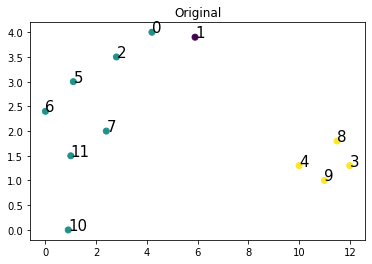

In [4]:
X, y = dataset.X, dataset.y

X_norm = Normalizer().fit_transform(X)

display_points(X, y, 'Original', numerate=True)
# display_points(X_norm, y, 'Normalized')

# DBSCAN (euclidean distance)

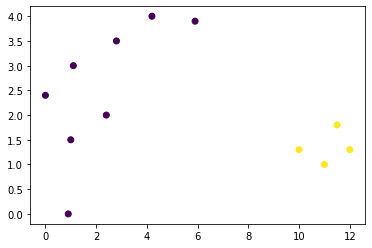

In [54]:
params = {
    'epsilon': 2,
    'minPts': 3,
    'similarity': euclidean_distance
}
y_pred, state, number_of_calc = dbscan(X, **params)
display_points(X, y_pred)
score = evaluate(y_pred, y, X)

In [6]:
log_info = pd.read_csv("out/dbscan_log.log", names=['Calculations', 'Current index', 'Time'])
log_info

,Calculations,Current index,Time
0,Eps,0.0,0.000048
1,Eps,1.0,0.000058
2,Eps,2.0,0.000040
3,Eps,5.0,0.000048
4,Eps,6.0,0.000039
5,Eps,11.0,0.000138
6,Eps,7.0,0.000040
7,Eps,10.0,0.000059
8,Eps,3.0,0.000042
9,Eps,4.0,0.000040


In [7]:
timer_out = time.time() 
out = pd.DataFrame({
    'point id': np.arange(X.shape[0]),
    'x': X[:, 0],
    'y': X[:, 1],
    'point type': state, # 1 - core, 0 - border, -1 - noise
    'CId': y_pred # clusters: cluster identifier or -1 in the case of noise points
})

out = out.merge(pd.DataFrame({
    'point id': number_of_calc.keys(), 
    '# of distance/similarity calculations': number_of_calc.values()
}), on='point id')

save_file(
    df=out, 
    file_type='OUT', 
    algorithm_name='dbscan', 
    dataset_name='example_from_lecture', 
    n_dimentions=X.shape[1], 
    n_rows=X.shape[0], 
    minPts=params['minPts'], 
    epsilon=params['epsilon']
)
out_time = time.time() - timer_out
print(out_time)
out

0.015219926834106445


,point id,x,y,point type,CId,# of distance/similarity calculations
0,0,4.2,4.0,1,1,3
1,1,5.9,3.9,0,1,2
2,2,2.8,3.5,1,1,4
3,3,12.0,1.3,1,2,4
4,4,10.0,1.3,1,2,4
5,5,1.1,3.0,1,1,5
6,6,0.0,2.4,1,1,3
7,7,2.4,2.0,1,1,4
8,8,11.5,1.8,1,2,4
9,9,11.0,1.0,1,2,4


In [48]:
out['# of distance/similarity calculations'].mean()

3.6666666666666665

In [55]:
timer_stat = time.time()
stat = pd.DataFrame({
    'name of the input fil': dataset.name,
    '# of dimensions of a point': X.shape[1],
    '# of points in the input file': X.shape[0],
    'epsilon': params['epsilon'],
    'minPts': params['minPts'],
    'similarity': params['similarity'].__name__,
    'version': ['dbscan'],
    "Eps-neighborhood timer": log_info['Time'][log_info['Calculations'] == 'Eps'].sum(),
    'Clustering timer': log_info['Time'][12],
    'OUT timer': out_time,
    '# of discovered clusters': len(set(y_pred[y_pred > 0])),
    '# of discovered noise points': sum(out['point type'] == -1),
    '# of discovered core points': sum(out['point type'] == 1),
    '# of discovered border points': sum(out['point type'] == 0),
    'avg # of calculations of distance/similarity': out['# of distance/similarity calculations'].mean(),
    'RAND':score['adjusted_rand_score'],
    'Purity':score['purity'],
    'Silhouette coefficient':score['silhouette_score_euclidean'],
    'Davies Bouldin': score['davies_bouldin_score']
    
})

# save_file(
#     df=stat, 
#     file_type='STAT', 
#     algorithm_name='dbscan', 
#     dataset_name='example_from_lecture', 
#     n_dimentions=X.shape[1], 
#     n_rows=X.shape[0], 
#     minPts='', 
#     epsilon=''
# )
stat_time = time.time() - timer_stat
print(stat_time)
stat

0.003325939178466797


,name of the input fil,# of dimensions of a point,# of points in the input file,epsilon,minPts,similarity,version,Eps-neighborhood timer,Clustering timer,OUT timer,# of discovered clusters,# of discovered noise points,# of discovered core points,# of discovered border points,avg # of calculations of distance/similarity,RAND,Purity,Silhouette coefficient,Davies Bouldin
0,lecture_dataset,2,12,2,3,euclidean_distance,dbscan,0.01501,0.014367,0.01522,2,0,10,2,3.666667,0.789041,0.916667,0.713755,0.307556


# DBSCANRN

### cosine dissimilarity, not optimized KNN

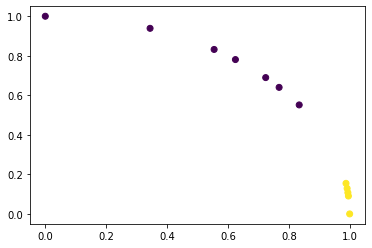

In [8]:
y_pred = dbscanrn(X=X_norm, k=4, similarity=cosine_dissimilarity)
display_points(X_norm, y_pred)

### cosine similarity, not optimized KNN

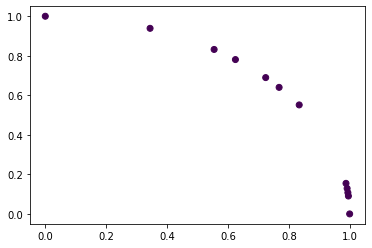

In [9]:
y_pred = dbscanrn(X=X_norm, k=4, similarity=cosine_similarity)
display_points(X_norm, y_pred)

### cosine dissimilarity, ti-KNN

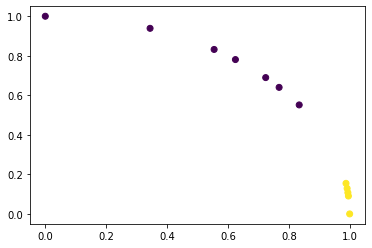

In [10]:
y_pred = ti_dbscanrn(X=X_norm, k=2, similarity=cosine_dissimilarity)
display_points(X_norm, y_pred)

### cosine similarity, ti-KNN

In [13]:
y_pred

array([1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1])

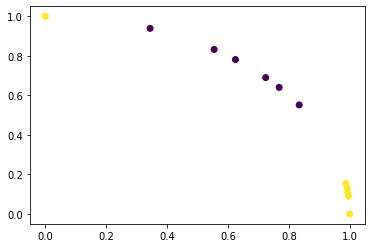

In [11]:
y_pred = ti_dbscanrn(X=X_norm, k=4, similarity=cosine_similarity)
display_points(X_norm, y_pred)

In [ ]:
# stat = pd.DataFrame({
#     'point id': [],
#     'x': [],
#     'y': [],
#     '# of distance/similarity calculations': [],
#     'point type': [],
#     'CId': []
# })
# out